## Imports

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


# from sklearn.linear_model import LogisticRegression #dont need
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

# from src.utils.pandas_extensions import one_hot_encoding

## Functions

In [ ]:
def replace_known_zero(df: pd.DataFrame, column: str) -> None:
    df[column] = df[column].replace("none", 0)
    df[column] = df[column].replace(np.nan, 0)
    df[column] = df[column].astype("float")

def clean_data(dataframe: pd.DataFrame, drop: bool = True, encode_attr: dict = {}, replace_attr: list[str] = [], date_cols: list[str] = []) -> pd.DataFrame:
    processed_data = dataframe.copy() 

    for col in encode_attr.keys():
        processed_data = one_hot_encoding(processed_data, col, possible_values=encode_attr[col])

    # processed_data = one_hot_encoding(processed_data, "Subscription Type")
    # processed_data = one_hot_encoding(processed_data, "Contract Length")
    # processed_data = one_hot_encoding(processed_data, "Gender")
    # processed_data = one_hot_encoding(processed_data, "Customer Status", possible_values=["active", "inactive"])

    for col in replace_attr:
        replace_known_zero(processed_data, column=col)

    for col in date_cols:
        processed_data[col] = pd.to_datetime(processed_data[col])

    # processed_data["Last Payment Month"] = processed_data["Last Payment Date"].datetime

    if drop:
        processed_data = processed_data.dropna()

    return processed_data

def one_hot_encoding(dataframe: pd.DataFrame, column: str, possible_values: list[str] = []) -> pd.DataFrame:
    if (column not in dataframe.columns):
        raise AssertionError(f"Column {column} doesn't exist")
    
    nparr = dataframe[column].value_counts()
    
    for new_col in possible_values:
        new_series = dataframe[column] == new_col
        dataframe[f"{column}_{new_col}"] = new_series

    for new_col in nparr.index:
        new_series = dataframe[column] == new_col
        dataframe[f"{column}_{new_col}"] = new_series


    return dataframe

## Settings

In [260]:
features = ["Usage Frequency", "Age", "Support Calls", "Last Interaction", "Total Spend", 
            "Contract Length_Monthly",
            "Gender_Male", "Gender_Female"
            # "Contract Length_Annual", "Contract Length_Quarterly"
            # "Subscription Type_Basic", "Subscription Type_Premium", "Subscription Type_Standard"
            # "Customer Status_inactive", "Customer Status_active"
        ]
depth_limit = 8
columns_to_encode = {
    "Subscription Type": [],
    "Contract Length": [],
    "Gender": [],
    "Customer Status": ["active", "inactive"]
}

# Keep payment delay in, this makes sure that the columns with none or NaN are not removeed.
columns_to_zero_set = ["Support Calls", "Tenure", "Payment Delay", "Last Interaction"] 

columns_to_parse_as_dates = ["Last Due Date", "Last Payment Date"]

## Load data

In [263]:
unprocessed_data = pd.read_csv("../data/raw/train.csv", parse_dates=columns_to_parse_as_dates)
unprocessed_data.head()
# unprocessed_data["Contract Length"].value_counts()

C:\Users\Scott\AppData\Local\Temp\ipykernel_41856\3273702437.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  unprocessed_data = pd.read_csv("../data/raw/train.csv", parse_dates=columns_to_parse_as_dates)
C:\Users\Scott\AppData\Local\Temp\ipykernel_41856\3273702437.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  unprocessed_data = pd.read_csv("../data/raw/train.csv", parse_dates=columns_to_parse_as_dates)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Customer Status,Last Due Date,Last Payment Date,Churn
0,160831,34,Male,NaN,26,none,17.0,Basic,Quarterly,890.21,30.0,active,06-21,07-08,0
1,354435,30,Male,36.0,22,NaN,15.0,Basic,Annual,954.37,30.0,active,06-10,06-25,0
2,444576,23,Male,44.0,14,none,NaN,Premium,Annual,674.00,21.0,inactive,06-27,07-21,1
3,130847,24,Male,39.0,21,2,14.0,Standard,Quarterly,775.00,18.0,active,06-30,07-14,0
4,108121,26,Male,NaN,26,1,5.0,Basic,Quarterly,679.45,NaN,active,06-29,07-04,0


## Clean Data

In [264]:
processed_data = clean_data(unprocessed_data, encode_attr=columns_to_encode, replace_attr=columns_to_zero_set)

## Clean Test
*should be no rows*

In [265]:
# print(unprocessed_data.head(n=20))
processed_data[processed_data.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,...,Subscription Type_Premium,Subscription Type_Standard,Subscription Type_Basic,Contract Length_Annual,Contract Length_Quarterly,Contract Length_Monthly,Gender_Male,Gender_Female,Customer Status_active,Customer Status_inactive


AttributeError: Can only use .dt accessor with datetimelike values

## Split Data
*70/30 train test split*

In [266]:
np.random.seed(311)
X = processed_data[features]
y = processed_data["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Train Model

In [267]:
#try ph with depth 1, ph with depth 4, ph with depth None
#try N as the features with the same depth value
#try cycle through the rest of the fa
# features = ["Usage Frequency", "Age", "Subscription Type_Premium", "Subscription Type_Basic", "Subscription Type_Standard"]
model = DecisionTreeClassifier(criterion='entropy', max_depth=depth_limit)
model.fit(X_train[features], y_train)

#Predict on train data
y_pred_train = model.predict(X_train[features])

#Predict on test data
y_pred_test = model.predict(X_test[features])

train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
train_f1_score = metrics.f1_score(y_train, y_pred_train)
train_auc_score = metrics.roc_auc_score(y_train, y_pred_train)
testing_accuracy = metrics.accuracy_score(y_test, y_pred_test)
testing_f1_score = metrics.f1_score(y_test, y_pred_test)
testing_auc_score = metrics.roc_auc_score(y_test, y_pred_test)

print("---------Training performance---------")
print(f"{train_accuracy=}")
print(f"{train_f1_score=}")
print(f"{train_auc_score=}")
print("---------Testing performance---------")
print(f"{testing_accuracy=}")
print(f"{testing_f1_score=}")
print(f"{testing_auc_score=}")

---------Training performance---------
train_accuracy=0.8897005457475988
train_f1_score=0.8353894414044367
train_auc_score=0.9021283669871354
---------Testing performance---------
testing_accuracy=0.8875057731641338
testing_f1_score=0.8322785847788307
testing_auc_score=0.8995853007974605


## Exploring Results
*test what features model used*

In [ ]:
plt.figure(figsize=(3,3))
plot_tree(model, feature_names=features, filled=True)
plt.title(f"Descision Tree ({features=}, {depth_limit=})")

[0.00470367 0.13465353 0.35941233 0.05513304 0.27228191 0.16064848
 0.00059979 0.01256726] ['Usage Frequency', 'Age', 'Support Calls', 'Last Interaction', 'Total Spend', 'Contract Length_Monthly', 'Gender_Male', 'Gender_Female']
8 8


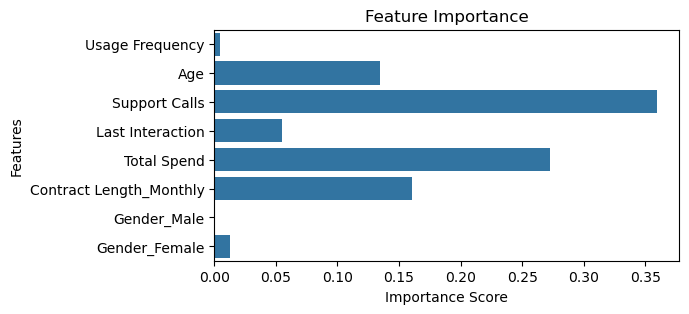

In [237]:
importances = model.feature_importances_
print(importances, features)
print(len(importances), len(features))

# Display feature importance
plt.figure(figsize=(6,3))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')          
plt.show()

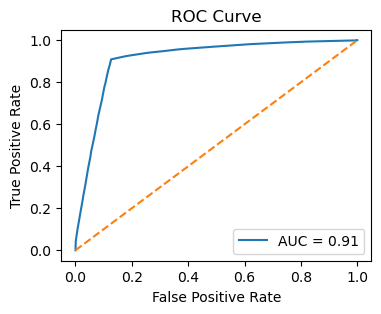

In [225]:
# AUC-ROC Curve
y_prob = model.predict_proba(X_test[features])[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
roc_auc = metrics.roc_auc_score(y_test, y_prob)

plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Submission

### Load

In [209]:
submission_df = pd.read_csv("../data/raw/test.csv")

In [115]:
for col in submission_df.columns:
    print(submission_df[col].value_counts())

CustomerID
262106    1
233745    1
190967    1
259611    1
6908      1
         ..
371859    1
285097    1
367255    1
94729     1
132430    1
Name: count, Length: 133776, dtype: int64
Age
37    2930
47    2914
50    2903
33    2902
46    2901
34    2894
42    2893
31    2882
43    2880
48    2874
45    2870
39    2860
35    2845
49    2841
38    2826
23    2825
44    2820
30    2817
40    2808
24    2792
41    2792
29    2791
25    2790
59    2785
36    2781
22    2778
55    2761
18    2758
26    2755
27    2753
20    2751
65    2750
57    2742
61    2740
51    2739
54    2736
63    2732
60    2731
28    2730
64    2712
52    2692
53    2689
56    2684
58    2684
32    2684
21    2673
19    2646
62    2640
Name: count, dtype: int64
Gender
Female    67449
Male      66327
Name: count, dtype: int64
Tenure
55.0    1927
37.0    1894
56.0    1881
57.0    1878
52.0    1873
34.0    1872
46.0    1870
39.0    1866
53.0    1866
29.0    1864
44.0    1861
47.0    1858
38.0    1858
60.0    1857
27.

### Predict

In [ ]:
test_data = pd.read_csv("../data/raw/test.csv")
test_data["Support Calls"].value_counts()
test_data = clean_data(test_data, drop=False, encode_attr=columns_to_encode, replace_attr=columns_to_zero_set)
# print(test_data)
test_prob = model.predict_proba(test_data[features])
test_pred = test_prob[:,1]

### Export

In [212]:
export = test_data[["CustomerID"]]
export["Churn"] = test_pred

date = datetime.now()
export.to_csv("../data/processed/" + str(date).replace(":", "") + ".csv", index=False)

C:\Users\Scott\AppData\Local\Temp\ipykernel_41856\1555304509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  export["Churn"] = test_pred
